In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = 'SimHei'
# plt.style.use('ggplot')

import seaborn as sns
sns.set_theme(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('BostonHousing.csv')  # Read the CSV file into a DataFrame.
df.head()                              # Show the first few rows of the DataFrame.

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
# Drop the 'medv' column from the DataFrame to create the feature matrix X.
# The 'medv' column is separated as the target variable y.
X, y = df.drop('medv', axis=1), df['medv']

In [4]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler.
scaler = StandardScaler()

# Fit the scaler to the data (excluding 'chas' column) and transform it.
scaled_features = scaler.fit_transform(X.drop('chas', axis=1))

# Convert the scaled features back into a DataFrame with the original column names (excluding 'chas').
X_scaled = pd.DataFrame(scaled_features, columns=X.drop('chas', axis=1).columns)

# Add the 'chas' column back to the DataFrame, as it was not scaled.
X_scaled['chas'] = X['chas']

# Display the first few rows of the scaled DataFrame to inspect the changes.
X_scaled.head()

,crim,zn,indus,nox,rm,age,dis,rad,tax,ptratio,b,lstat,chas
0,-0.419782,0.284830,-1.287909,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0
1,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,0
2,-0.417342,-0.487722,-0.593381,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,0
3,-0.416750,-0.487722,-1.306878,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,0
4,-0.412482,-0.487722,-1.306878,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,0


In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(df):
    # Define a function to calculate the Variance Inflation Factor (VIF) for each feature.
    vif_data = pd.DataFrame()
    vif_data['Features'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]  # Calculate VIF for each feature.
    vif_data['VIF'] = round(vif_data['VIF'], 2)
    return vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)  # Sort the DataFrame by VIF in descending order.

# Call the function on the scaled features excluding the 'chas' column.
vif_result = vif(X_scaled.drop('chas', axis=1))

# Display the VIF results.
vif_result

,Features,VIF
0,tax,8.88
1,rad,7.40
2,nox,4.39
3,indus,3.95
4,dis,3.95
5,age,3.09
6,lstat,2.93
7,zn,2.30
8,rm,1.93
9,crim,1.79


In [6]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into 80% train and 20% test datasets with a fixed random state for reproducibility.
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [7]:
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error

def train(X, y):
    # Define a function to train an Ordinary Least Squares (OLS) regression model using statsmodels.
    X_sm = sm.add_constant(X)
    lr = sm.OLS(y, X_sm).fit()
    return lr

# Train the OLS regression model on the scaled training data.
lr = train(X_train_scaled, y_train)

# Predict on the test set by adding a constant term to the scaled test features.
y_pred = lr.predict(sm.add_constant(X_test_scaled))

# Calculate and print the root mean squared error (RMSE) of the predictions on the test set.
print('Test RMSE:', np.round(root_mean_squared_error(y_test, y_pred), 2))

# Display a detailed summary of the fitted OLS model.
lr.summary()

Test RMSE: 4.93


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     90.43
Date:                Mon, 09 Dec 2024   Prob (F-statistic):          6.21e-109
Time:                        09:48:15   Log-Likelihood:                -1194.3
No. Observations:                 404   AIC:                             2417.
Df Residuals:                     390   BIC:                             2473.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.2927      0.245     90.848      0.000      21.810      22.775
crim          -0.9715      0.299     -3.250      0.001      -1.559      -0.384
zn             0.7016      0.373      1.882      0.061      -0.031       1.434
indus          0.2768      0.462      0.599      0.549      -0.631       1.184
nox           -1.9914      0.490     -4.061      0.000      -2.956      -1.027
rm             3.1157      0.326      9.567      0.000       2.475       3.756
age           -0.1771      0.410     -0.432      0.666      -0.982       0.628
dis           -3.0458      0.475     -6.408      0.000      -3.980      -2.111
rad            2.2828      0.661      3.454      0.001       0.983       3.582
tax           -1.7926      0.715     -2.508      0.013      -3.198      -0.388
ptratio       -1.9800      0.311     -6.357      0.000      -2.592      -1.368
b              1.1265      0.270      4.166      0.000       0.595       1.658
lstat         -3.6281      0.397     -9.133      0.000      -4.409      -2.847
chas           2.7844      0.956      2.914      0.004       0.905       4.663
==============================================================================
Omnibus:                      133.052   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.817
Skew:                           1.379   Prob(JB):                    1.24e-126
Kurtosis:                       8.181   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Initialize a Linear Regression model.
lr = LinearRegression()

# Initialize Recursive Feature Elimination (RFE) with the linear regression model as the estimator and select the top 10 features.
rfe = RFE(estimator=lr, n_features_to_select=11)

# Fit the RFE model on the scaled feature data and target variable.
rfe = rfe.fit(X_train_scaled, y_train)

# Extract the names of the selected features using the support_ attribute.
selected_columns = X_scaled.columns[rfe.support_]

# Display the names of the selected columns.
selected_columns

Index(['crim', 'zn', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat',
       'chas'],
      dtype='object')

In [9]:
# Train and evaluate the OLS regression model on the scaled training data with selected features.
lr = train(X_train_scaled[selected_columns], y_train)
y_pred = lr.predict(sm.add_constant(X_test_scaled[selected_columns]))
print('Test RMSE:', np.round(root_mean_squared_error(y_test, y_pred), 2))
lr.summary()

Test RMSE: 4.91


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     107.2
Date:                Mon, 09 Dec 2024   Prob (F-statistic):          7.52e-111
Time:                        09:48:15   Log-Likelihood:                -1194.6
No. Observations:                 404   AIC:                             2413.
Df Residuals:                     392   BIC:                             2461.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.2870      0.245     91.081      0.000      21.806      22.768
crim          -0.9788      0.298     -3.283      0.001      -1.565      -0.393
zn             0.6895      0.368      1.876      0.061      -0.033       1.412
nox           -1.9620      0.455     -4.308      0.000      -2.857      -1.067
rm             3.0622      0.315      9.711      0.000       2.442       3.682
dis           -3.0309      0.441     -6.869      0.000      -3.898      -2.163
rad            2.2084      0.639      3.456      0.001       0.952       3.465
tax           -1.6270      0.656     -2.479      0.014      -2.918      -0.337
ptratio       -1.9746      0.308     -6.411      0.000      -2.580      -1.369
b              1.1129      0.269      4.133      0.000       0.584       1.642
lstat         -3.6632      0.377     -9.705      0.000      -4.405      -2.921
chas           2.8311      0.948      2.985      0.003       0.967       4.696
==============================================================================
Omnibus:                      130.816   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              555.631
Skew:                           1.363   Prob(JB):                    2.22e-121
Kurtosis:                       8.058   Cond. No.                         9.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

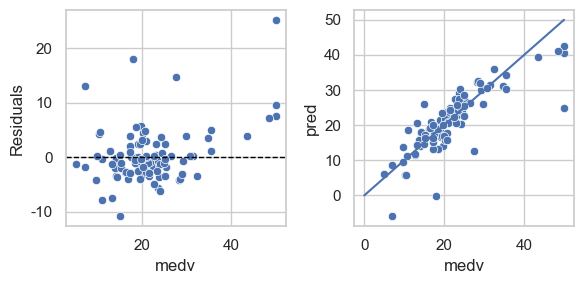

In [10]:
# Create a figure with two subplots side by side.
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(6)
fig.set_figheight(3)
ax1, ax2 = ax

# Plot residuals against actual values in the first subplot.
sns.scatterplot(x=y_test, y=y_test-y_pred, ax=ax1)
ax1.axhline(0, linestyle='--', color='black', linewidth=1)
ax1.set_xlabel('medv')
ax1.set_ylabel('Residuals')

# Plot actual vs. predicted values in the second subplot.
sns.scatterplot(x=y_test, y=y_pred, ax=ax2)
ax2.plot([0, 50], [0, 50])
ax2.set_ylabel('pred')

# Adjust the layout to ensure elements do not overlap and display the plots.
plt.tight_layout()
plt.show()

In [11]:
from statsmodels.stats.outliers_influence import OLSInfluence

# Initialize the OLSInfluence object with the fitted OLS model.
influence = OLSInfluence(lr)

# Extract Cook's distance for each observation from the influence object.
cooks_distance = influence.cooks_distance[0]

# Filter and display observations where Cook's distance is greater than 1, indicating potential outliers.
outliers = cooks_distance[cooks_distance > 1]

# Display the indices of the observations that are considered influential (Cook's distance > 1).
outliers_indices = np.where(cooks_distance > 1)[0]
outliers_indices

array([], dtype=int64)